# Computer Vision & Deep Learning - Generative AI & Visual Synthesis

# Exercise 4: Convolutional Neural Networks

**Due on 24.05.2024., 10:00**

## Important notes

- Email: Frequently check your email address registered for Moodle. All notifications regarding the course will be sent via Moodle.
- Moodle: Please use the Moodle platform and post your questions to the forum. They will be answered by us or your fellow students.
-  Submission: Put your code and potentially other materials inside a single ZIP file. If you use jupyter notebooks, please always create a PDF file and include it in your ZIP file. The final submission should therefore be a **single zip** file with a **PDF of your code** and the **original code** inside. The ZIP file should contain your surname and your matriculation number (Surname-MatriculationNumber.zip). Submissions that fail to follow the naming convention will not be graded!

In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms as T

---
## Task 3: Convolutional Neural Networks

In the previous exercise, we already used the PyTorch framework to train a neural network classifier. Now, we want to move on to a more complex dataset than MNIST and use a Convolutional Neural Network for classification.

### Task 3.1: Dataset

Files already downloaded and verified
X: (50000, 32, 32, 3)
Y: (50000,)


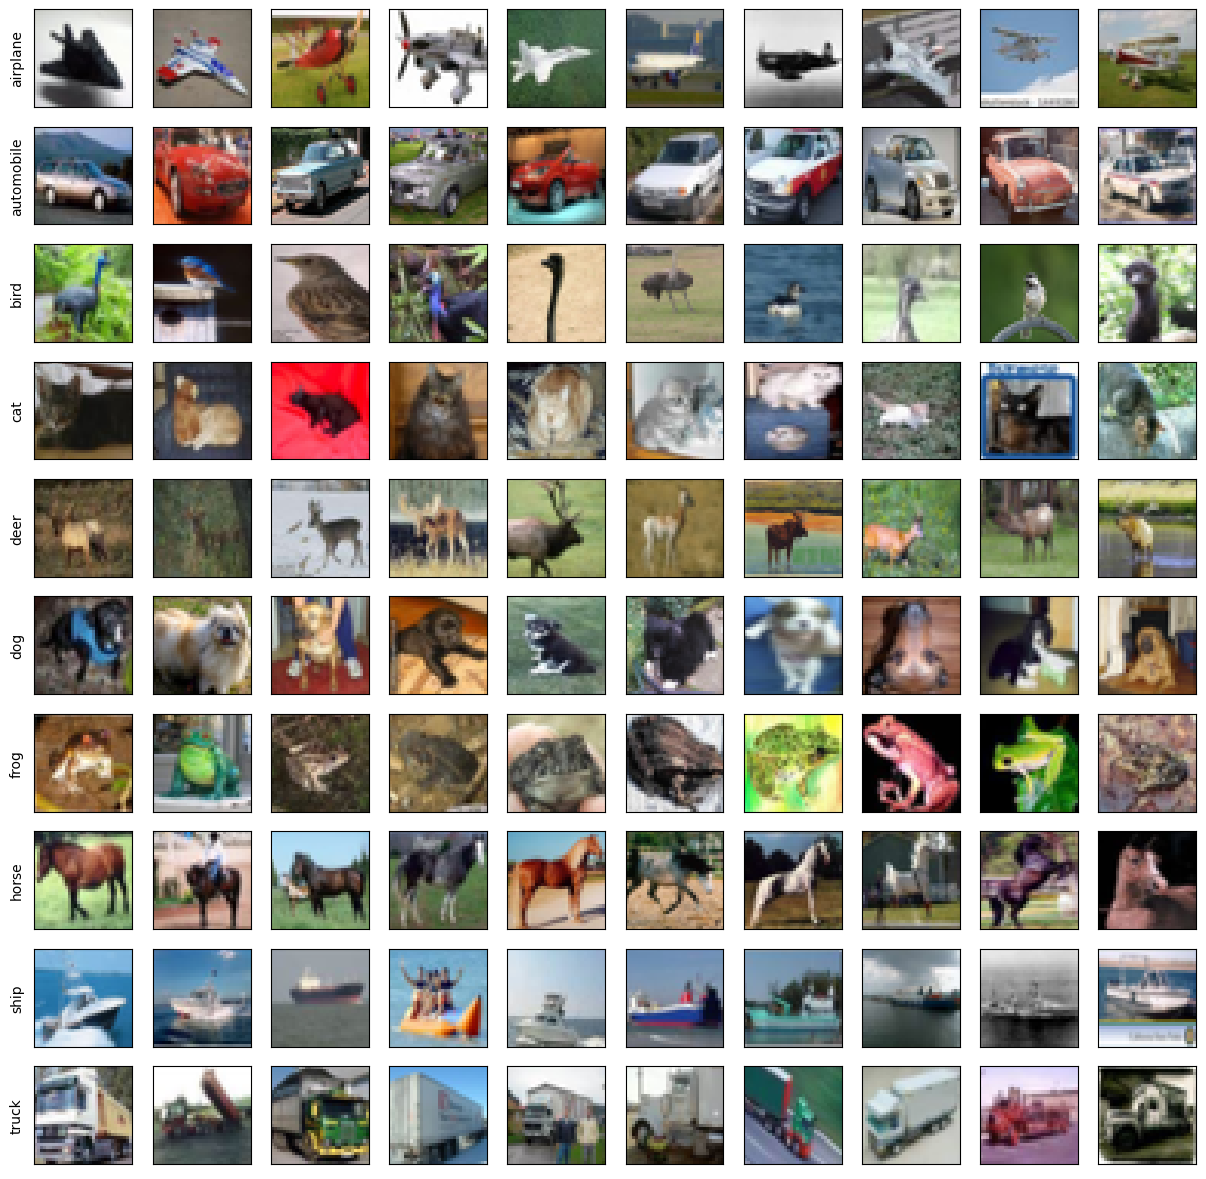

In [2]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

# Print some information about the dataset
x = dataset.data
y = np.array(dataset.targets)
print("X:", x.shape)
print("Y:", y.shape)

# Plot 10 images from each class
fig, axes = plt.subplots(10, 10, figsize=(15, 15))

for class_label in range(10):
    inds = np.where(y == class_label)[0]
    inds = inds[:10]
    ims = x[inds]
    for i, im in enumerate(ims):
        axes[class_label, i].imshow(im)
        axes[class_label, i].set_xticks([])
        axes[class_label, i].set_yticks([])
        if i == 0:
            axes[class_label, i].set_ylabel(dataset.classes[class_label])
plt.show()

### 3.2 Network

In [3]:
class Net(nn.Module):
    def __init__(self):
        ############ your code here ############
        
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding=0, stride=1)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0, stride=1)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        ############ end of your code############
    
    def forward(self, x):
        ############ your code here ############

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
        ############ end of your code############

net = Net()
print(f"Params: {sum(p.numel() for p in net.parameters() if p.requires_grad):,}")

Params: 62,006


### 3.3 Training

In [4]:
def train_epoch(network, loader, opt, criterion, dev):
    network.train()
    train_accs = []
    for i, data in enumerate(tqdm(loader)):
        inputs, labels = data[0], data[1]

        # inputs to gpu
        inputs, labels = inputs.to(dev), labels.to(dev)

        # reset gradient parameter
        opt.zero_grad()

        # optimize
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        opt.step()
        
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        train_accs.append(acc.item())
        
    train_acc = np.mean(train_accs)
    return train_acc


def eval_epoch(network, loader, dev):
    correct = 0
    total = 0
    network.eval()
    with torch.no_grad():
        for data in loader:
            inputs, labels = data[0], data[1]
            inputs, labels = inputs.to(dev), labels.to(dev)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = correct / total
    return val_acc

In [5]:
# prepare train and test sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=T.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=T.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, drop_last=True)

# use cuda if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# choose network
net = Net()
net.to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

# train model
n_epochs = 10
accuracies = dict(train=[], val=[])
for epoch in range(n_epochs):  # loop over the dataset multiple times
    # training
    train_acc = train_epoch(net, trainloader, optimizer, criterion, device)
    
    # evaluate
    val_acc = eval_epoch(net, testloader, device)

    # save accuracies
    accuracies['train'].append(train_acc)
    accuracies['val'].append(val_acc)
    print(f"*** Summary [{epoch+1} / {n_epochs}]: train_acc={train_acc:.4f}, val_acc={val_acc:.4f} ***\n")

Files already downloaded and verified
Files already downloaded and verified
cpu


100%|██████████| 3125/3125 [00:13<00:00, 223.58it/s]


*** Summary [1 / 10]: train_acc=0.3496, val_acc=0.4263 ***



100%|██████████| 3125/3125 [00:14<00:00, 219.84it/s]


*** Summary [2 / 10]: train_acc=0.4517, val_acc=0.4797 ***



100%|██████████| 3125/3125 [00:13<00:00, 224.31it/s]


*** Summary [3 / 10]: train_acc=0.4977, val_acc=0.5144 ***



100%|██████████| 3125/3125 [00:13<00:00, 227.10it/s]


*** Summary [4 / 10]: train_acc=0.5302, val_acc=0.5253 ***



100%|██████████| 3125/3125 [00:13<00:00, 230.65it/s]


*** Summary [5 / 10]: train_acc=0.5536, val_acc=0.5493 ***



100%|██████████| 3125/3125 [00:14<00:00, 221.66it/s]


*** Summary [6 / 10]: train_acc=0.5708, val_acc=0.5602 ***



100%|██████████| 3125/3125 [00:13<00:00, 224.09it/s]


*** Summary [7 / 10]: train_acc=0.5872, val_acc=0.5581 ***



100%|██████████| 3125/3125 [00:13<00:00, 230.65it/s]


*** Summary [8 / 10]: train_acc=0.5992, val_acc=0.5702 ***



100%|██████████| 3125/3125 [00:14<00:00, 220.16it/s]


*** Summary [9 / 10]: train_acc=0.6121, val_acc=0.5503 ***



100%|██████████| 3125/3125 [00:14<00:00, 221.16it/s]


*** Summary [10 / 10]: train_acc=0.6216, val_acc=0.5746 ***



Plot how the accuracy (i.e. percentage of correctly classified images) of your model evolves for both, the training- and test-set of CIFAR10. Please make sure to add meaningful axis labels for your plot (y-axis as
the accuracy and x-axis as the epoch number).

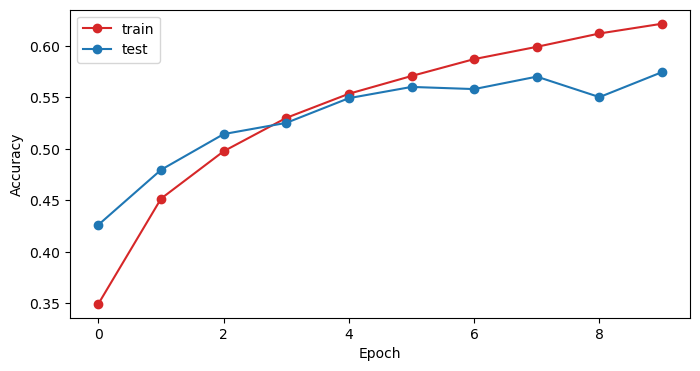

In [6]:
plt.subplots(1, 1, figsize=(8, 4))
plt.plot(accuracies['train'], '-o', color="C3", label='train')
plt.plot(accuracies['val'], '-o', color="C0", label='test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

What do you observe in the accuracy plot, in particular if you compare the train and test accuracy? Do you have an explanation for that?

**SOLUTION**: *We can observe that the accuracy on the train set further increases, while performance on the test set stagnates. This is usually called overfitting in machine learning, where models tend to overfit on training data and loose their generalizability.*

### 3.4 Augmentation

Please apply random horizontal flipping, random cropping with padding=4, and ColorJitter to the CIFAR10 images and visualize a few pairs of augmented images against their original.

Files already downloaded and verified
Files already downloaded and verified


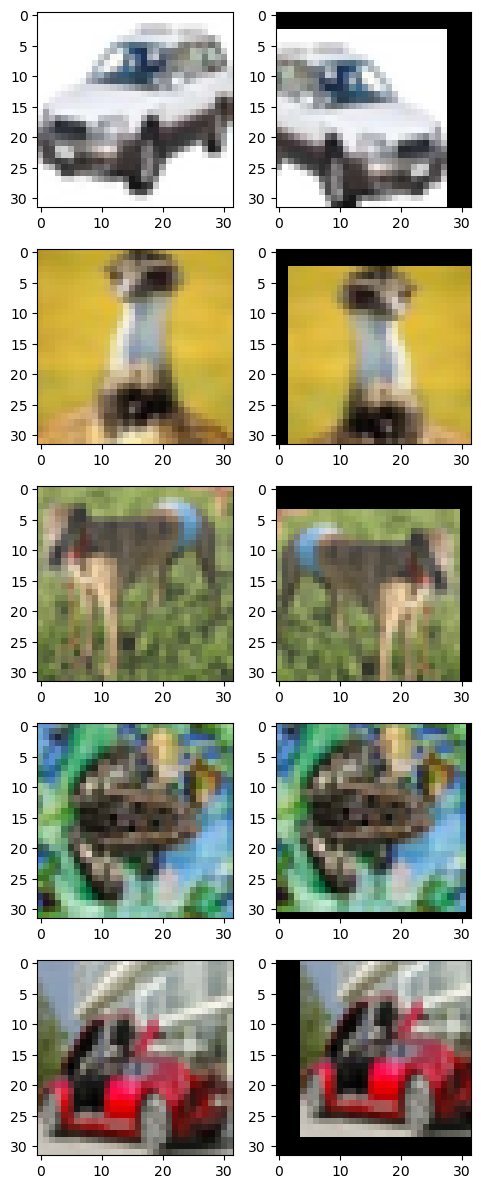

In [7]:
transform_train = T.Compose([
    T.RandomCrop(32, padding=4),
    # T.ColorJitter(brightness=.5, hue=.3),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_val = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# prepare train and test sets
trainset_base = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=T.ToTensor())
trainloader_base = torch.utils.data.DataLoader(trainset_base, batch_size=16, shuffle=True, drop_last=True)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, drop_last=True)

fig, ax = plt.subplots(5, 2, figsize=(5, 12))
for i in range(5):
    idx = np.random.choice(5000)
    base = trainloader_base.dataset.__getitem__(idx)[0].permute(1,2,0)
    aug = trainloader.dataset.__getitem__(idx)[0].permute(1,2,0)
    aug = (aug * 0.5 + 0.5).numpy()         # don't forget to denormalize
    ax[i][0].imshow(base)
    ax[i][1].imshow(aug)

fig.tight_layout()
plt.show()

Train your model using the same setup as above, however, with additional normalization (normalize your input images channel-wise using μ = 0.5 and σ = 0.5) and data augmentation.

In [8]:
transform_train = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_val = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# prepare train and test sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, drop_last=True)

# use cuda if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# choose network
net = Net()
net.to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

# train model
n_epochs = 10
aug_accuracies = dict(train=[], val=[])

for epoch in range(n_epochs):  # loop over the dataset multiple times
    # training
    train_acc = train_epoch(net, trainloader, optimizer, criterion, device)
    
    # evaluate
    val_acc = eval_epoch(net, testloader, device)

    # save accuracies
    aug_accuracies['train'].append(train_acc)
    aug_accuracies['val'].append(val_acc)

    print(f"*** Summary [{epoch+1} / {n_epochs}]: train_acc={train_acc:.4f}, val_acc={val_acc:.4f} ***\n")

Files already downloaded and verified
Files already downloaded and verified
cpu


100%|██████████| 3125/3125 [00:16<00:00, 188.39it/s]


*** Summary [1 / 10]: train_acc=0.3722, val_acc=0.4522 ***



100%|██████████| 3125/3125 [00:17<00:00, 179.54it/s]


*** Summary [2 / 10]: train_acc=0.4663, val_acc=0.5357 ***



100%|██████████| 3125/3125 [00:16<00:00, 194.56it/s]


*** Summary [3 / 10]: train_acc=0.5118, val_acc=0.5596 ***



100%|██████████| 3125/3125 [00:16<00:00, 194.81it/s]


*** Summary [4 / 10]: train_acc=0.5411, val_acc=0.5885 ***



100%|██████████| 3125/3125 [00:16<00:00, 192.64it/s]


*** Summary [5 / 10]: train_acc=0.5580, val_acc=0.6011 ***



100%|██████████| 3125/3125 [00:16<00:00, 190.50it/s]


*** Summary [6 / 10]: train_acc=0.5718, val_acc=0.6122 ***



100%|██████████| 3125/3125 [00:16<00:00, 190.68it/s]


*** Summary [7 / 10]: train_acc=0.5840, val_acc=0.6346 ***



100%|██████████| 3125/3125 [00:17<00:00, 176.26it/s]


*** Summary [8 / 10]: train_acc=0.5932, val_acc=0.6184 ***



100%|██████████| 3125/3125 [00:18<00:00, 169.70it/s]


*** Summary [9 / 10]: train_acc=0.6020, val_acc=0.6266 ***



100%|██████████| 3125/3125 [00:17<00:00, 177.92it/s]


*** Summary [10 / 10]: train_acc=0.6025, val_acc=0.6420 ***



Heavy augmentations.

In [12]:
transform_train = T.Compose([
    T.RandomCrop(32, padding=6),
    T.ColorJitter(brightness=.8, hue=.3),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_val = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# prepare train and test sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, drop_last=True)

# use cuda if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# choose network
net = Net()
net.to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

# train model
n_epochs = 10
heavy_aug_accuracies = dict(train=[], val=[])

for epoch in range(n_epochs):  # loop over the dataset multiple times
    # training
    train_acc = train_epoch(net, trainloader, optimizer, criterion, device)
    
    # evaluate
    val_acc = eval_epoch(net, testloader, device)
    
    # save accuracies
    heavy_aug_accuracies['train'].append(train_acc)
    heavy_aug_accuracies['val'].append(val_acc)

    print(f"*** Summary [{epoch+1} / {n_epochs}]: train_acc={train_acc:.4f}, val_acc={val_acc:.4f} ***\n")

Files already downloaded and verified
Files already downloaded and verified
cpu


100%|██████████| 3125/3125 [00:21<00:00, 145.22it/s]


*** Summary [1 / 10]: train_acc=0.2642, val_acc=0.4070 ***



100%|██████████| 3125/3125 [00:20<00:00, 149.26it/s]


*** Summary [2 / 10]: train_acc=0.3615, val_acc=0.4493 ***



100%|██████████| 3125/3125 [00:21<00:00, 147.49it/s]


*** Summary [3 / 10]: train_acc=0.4026, val_acc=0.4799 ***



100%|██████████| 3125/3125 [00:21<00:00, 147.22it/s]


*** Summary [4 / 10]: train_acc=0.4256, val_acc=0.4887 ***



100%|██████████| 3125/3125 [00:20<00:00, 149.84it/s]


*** Summary [5 / 10]: train_acc=0.4372, val_acc=0.5304 ***



100%|██████████| 3125/3125 [00:21<00:00, 145.30it/s]


*** Summary [6 / 10]: train_acc=0.4584, val_acc=0.5241 ***



100%|██████████| 3125/3125 [00:21<00:00, 144.85it/s]


*** Summary [7 / 10]: train_acc=0.4633, val_acc=0.5552 ***



100%|██████████| 3125/3125 [00:21<00:00, 144.33it/s]


*** Summary [8 / 10]: train_acc=0.4763, val_acc=0.5421 ***



100%|██████████| 3125/3125 [00:21<00:00, 148.05it/s]


*** Summary [9 / 10]: train_acc=0.4796, val_acc=0.5601 ***



100%|██████████| 3125/3125 [00:21<00:00, 144.35it/s]


*** Summary [10 / 10]: train_acc=0.4894, val_acc=0.5676 ***



Plot the accuracy of this model and the one you trained before over time. Make sure to use proper axis labels and a meaningful legend.

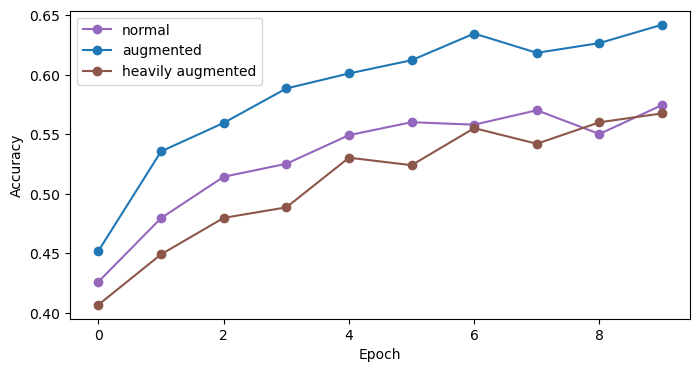

In [13]:
plt.subplots(1, 1, figsize=(8, 4))
# plot accuracies for non-augmented data
plt.plot(accuracies['val'], '-o', c='C4', label='normal')
# plot accuracies for augmented data
plt.plot(aug_accuracies['val'], '-o', c='C0', label='augmented')
# plot accuracies for heavily augmented data
plt.plot(heavy_aug_accuracies['val'], '-o', c='C5', label='heavily augmented')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Based on your results, provide a brief discussion of why the extra normalization and augmentation improves/harms the performance of your model.

Pros
- avoid overfitting
- better generalization
- increase variety of dataset
- induce invariances

Contras
- heavy augmentation can harm performance
- data off the manifold

#### Why normalize inputs?
A short tutorial by Andrew Ng: https://www.youtube.com/watch?v=FDCfw-YqWTE

---